In [1]:
from tensorflow.keras.models import load_model

In [15]:
data = np.load(r"C:\Users\vasek\Downloads\TrainTestforUnet.npz")

In [19]:
print(data.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [21]:
x_train = data['x_train']
x_val = data['x_val']
x_test = data['x_test']

y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

In [3]:
model=load_model(r"C:\Users\vasek\Downloads\FinalModelTrainTest.keras")

In [7]:
import tensorflow as tf
import numpy as np

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)  # Flatten to 1D
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Count overlapping pixels
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2. * intersection + smooth) / (union + smooth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
IoU Score : 0.9277962


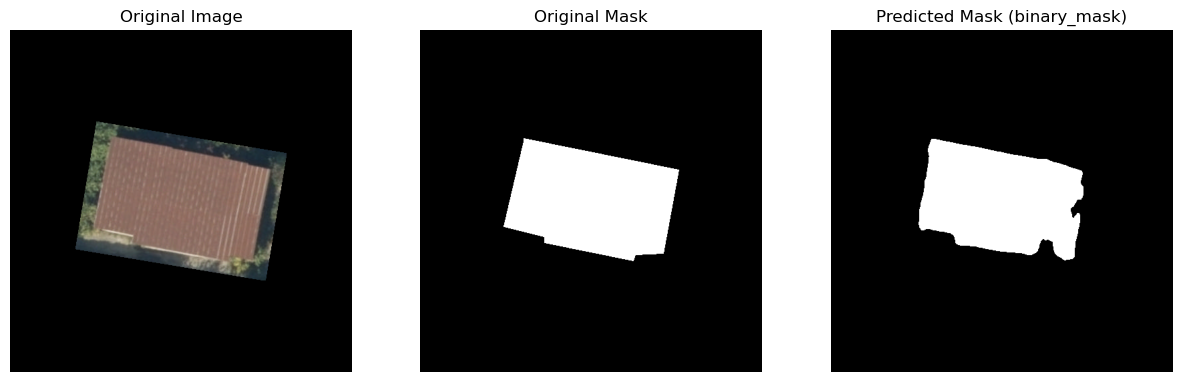

In [79]:
from posixpath import isabs
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array


#<--------------------------------------------------------------------------------------------------------------------------->
# Predict on a single image
def predict_and_visualize(image_path, label_path, model):
    image = img_to_array(load_img(image_path, target_size=(512, 512))) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)[0, ..., 0]  # Remove batch and channel dimensions

    y_pred = tf.cast(prediction > 0.5, tf.float32)
    # print("Predicted Label",y_pred)
    #loading true lable
    lab= img_to_array(load_img(label_path, target_size=(512, 512), color_mode="grayscale")) / 255.0
   # Remove extra dimension (512, 512, 1) → (512, 512)
    lab= tf.squeeze(lab)
    y_true=  tf.cast(lab> 0, tf.float32)
  

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    # Avoid division by zero
    iou = intersection / (union + tf.keras.backend.epsilon())
    print("IoU Score :",iou.numpy())
    #<--------------------------------------------------------------------------------------------------------------------------->
    
    # Display original image and prediction
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image[0])
    plt.axis('off')
    #Original mask
    plt.subplot(1, 3, 2)
    plt.title("Original Mask")
    plt.imshow(lab, cmap='gray')
    plt.axis('off')
    
    #<--------------------------------------------------------------------------------------------------------------------------->

# Assuming `predicted_mask` is the grayscale mask
    threshold =0.5# Adjust threshold as necessary
    binary_mask = (prediction > threshold).astype(np.uint8)
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (binary_mask)")
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')
    plt.show()
   
    
 #<--------------------------------------------------------------------------------------------------------------------------->

predict_and_visualize(r"C:\Users\vasek\Documents\Model\streamlit\PV\r1771.tif",r"C:\Users\vasek\Documents\Model\streamlit\labels\r1771_label.tif", model)


In [59]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

# Function to calculate Dice Score
def calculate_dice(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

def accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    correct = tf.equal(y_true, y_pred)  # Compare predictions with ground truth
    return tf.reduce_mean(tf.cast(correct, tf.float32)) 

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = tf.reduce_sum(y_true * y_pred)  # Count correctly predicted foreground pixels
    possible_positives = tf.reduce_sum(y_true)  # Total foreground pixels in ground truth
    return true_positives / (possible_positives + tf.keras.backend.epsilon())


def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = tf.reduce_sum(y_true * y_pred)  # Count correctly predicted foreground pixels
    predicted_positives = tf.reduce_sum(y_pred)  # Total predicted foreground pixels
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())


def evaluate_dataset(model, X, y):
    """ Evaluate Accuracy, IoU, Precision, Recall, and Dice Score for a dataset. """
    iou_scores, dice_scores, accuracies, precisions, recalls = [], [], [], [], []
    count=0

    for i in range(len(X)):
        image = np.expand_dims(X[i], axis=0)  # Add batch dimension
        true_mask = y[i]
        true_mask= tf.squeeze(true_mask)
        true_mask= tf.cast(true_mask> 0, tf.float32)

        # Get model prediction
        pred_mask = model.predict(image, verbose=0)[0, ..., 0]  # Remove batch dim
        pred_mask =  tf.cast(pred_mask> 0.5, tf.float32)  # Convert to binary mask

        # Calculate metrics
        iou_scores.append(calculate_iou(true_mask, pred_mask))
        dice_scores.append(calculate_dice(true_mask, pred_mask))
        accuracies.append(accuracy(true_mask, pred_mask))
        precisions.append(precision(true_mask, pred_mask))
        recalls.append(recall(true_mask, pred_mask))
        count=count+1
        print(count)
                          

    # Compute mean scores
    return {
        "Mean Accuracy": np.mean(accuracies),
        "Mean IoU": np.mean(iou_scores),
        "Mean Dice Score": np.mean(dice_scores),
        "Mean Precision": np.mean(precisions),
        "Mean Recall": np.mean(recalls),
    }


In [61]:
train_metrics = evaluate_dataset(model, x_train, y_train)
val_metrics = evaluate_dataset(model, x_val, y_val)
test_metrics = evaluate_dataset(model, x_test, y_test)

print("Train Metrics:", train_metrics)
print("Validation Metrics:", val_metrics)
print("Test Metrics:", test_metrics)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
